# Neural Style Transfer for Styling Travelling Place.

Name: Anthony Kevin Oktavius

Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time

Preprocess the image.

In [ ]:
def preview_image(image):
  plt.imshow(image)

def load_processor():
  return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_image(path, img_transform, interpolation_type, size = (400,400), show_img = True, device = load_processor()):
  image = Image.open(path)
  resized_image = image.resize(size, interpolation_type)
  transformed_image = img_transform(resized_image)
  if len(transformed_image.shape) == 3: # If the size of the image doesn't have a batch size.
    transformed_image = transformed_image.unsqueeze(0)
  
  if show_img:
    preview_image(resized_image)

  return transformed_image.to(device)

# Compute gram matrices.
def get_gram(matrix):
  _, channels, height, width = matrix.size()
  gram_matrix = matrix.view(channels, height * width)
  gram_matrix = torch.mm(gram_matrix, gram_matrix.t())
  return gram_matrix

# Denormalization image (opposite of transform), to visualize the image.
# Get mean and standard deviation from ImageNet statistics.
def denormalize_img(inp, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
  inp = inp.numpy().transpose((1, 2, 0))
  # Inverse mean and standard deviation.
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  return inp

Make Various Transfer Learning Model to see if the model has .

In [ ]:
class NeuralStyleTransferModel(nn.Module):
  def __init__(self):
    super(NeuralStyleTransferModel, self).__init__()
    self.selected_layers = []
    self.tl_network = None # Transfer Learning Model.

  def get_model_summary(self):
    return self.tl_network

  def get_pytorch_model_name(self):
    return ""

  def forward(self, x):
    layer_features = []

    for layer_number, layer in self.tl_network._modules.items():
      x = layer(x)
      if int(layer_number) in self.selected_layers:
        layer_features.append(x)

    return layer_features

class VGG19StyleTransferModel(NeuralStyleTransferModel):
  def __init__(self):
    super(VGG19StyleTransferModel, self).__init__()
    self.selected_layers = [3, 13, 22, 27]
    self.tl_network = models.vgg19(pretrained = True).features

  def get_pytorch_model_name(self):
    return "VGG19"

class EfficientNetStyleTransferModel(NeuralStyleTransferModel):
  def __init__(self):
    super(EfficientNetStyleTransferModel, self).__init__()
    self.selected_layers = [0, 3, 5, 7]
    self.tl_network = models.efficientnet_b0(pretrained = True).features

  def get_pytorch_model_name(self):
    return "EfficientNet"

class MobileNetStyleTransferModel(NeuralStyleTransferModel):
  def __init__(self):
    super(MobileNetStyleTransferModel, self).__init__()
    self.selected_layers = [3, 4, 14, 15]
    self.tl_network = models.mobilenet_v3_large(pretrained = True).features

  def get_pytorch_model_name(self):
    return "MobileNet"

class AlexNetStyleTransferModel(NeuralStyleTransferModel):
  def __init__(self):
    super(AlexNetStyleTransferModel, self).__init__()
    self.selected_layers = [1, 4, 7, 11]
    self.tl_network = models.alexnet(pretrained = True).features

  def get_pytorch_model_name(self):
    return "AlexNet"

class ConvNetStyleTransferModel(NeuralStyleTransferModel):
  def __init__(self):
    super(ConvNetStyleTransferModel, self).__init__()
    self.selected_layers = [0, 5, 10, 22]
    self.tl_network = models.convnext_base(pretrained = True).features

  def get_pytorch_model_name(self):
    return "ConvNet"

Preview All Layers of Pretrained Model

In [ ]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

images_directory_drive = "/content/drive/MyDrive/Dataset/Neural Style Transfer"

def load_dataset_image(sample_img_path = f"{images_directory_drive}/Wajah.jpg", style_img_path = f"{images_directory_drive}/Batik 1.jpg", img_transform = img_transform):
  sample_img = get_image(f"{sample_img_path}", img_transform, Image.LANCZOS, show_img = False)
  style_img = get_image(f"{style_img_path}", img_transform, Image.LANCZOS, show_img = False)
  generated_img = sample_img.clone()
  generated_img.requires_grad = True
  return sample_img, style_img, generated_img

def load_style_transfer_learning_model(StyleTransferModel, generated_img):
  device = load_processor()
  optimizer = torch.optim.Adam([generated_img], lr = 0.6, betas = [0.5, 0.999])
  style_transfer_model = StyleTransferModel().to(device)

  for param in style_transfer_model.parameters():
    param.requires_grad = False

  return style_transfer_model, optimizer

vgg_sample_img, vgg_style_img, vgg_generated_img = load_dataset_image()
vgg_style_transfer_model, vgg_optimizer = load_style_transfer_learning_model(VGG19StyleTransferModel, vgg_generated_img)

efficient_sample_img, efficient_style_img, efficient_generated_img = load_dataset_image()
efficient_style_transfer_model, efficient_optimizer = load_style_transfer_learning_model(EfficientNetStyleTransferModel, efficient_generated_img)

mobile_sample_img, mobile_style_img, mobile_generated_img = load_dataset_image()
mobile_style_transfer_model, mobile_optimizer = load_style_transfer_learning_model(MobileNetStyleTransferModel, mobile_generated_img)

alex_sample_img, alex_style_img, alex_generated_img = load_dataset_image()
alex_style_transfer_model, alex_optimizer = load_style_transfer_learning_model(AlexNetStyleTransferModel, alex_generated_img)

convnet_sample_img, convnet_style_img, convnet_generated_img = load_dataset_image()
nasnet_style_transfer_model, nasnet_optimizer = load_style_transfer_learning_model(ConvNetStyleTransferModel, convnet_generated_img)

See properties of the models.

In [ ]:
def pretty_print(what_to_print, title):
  print("=========================================")
  print(f"Printing: {title}")
  print(what_to_print)
  print("=========================================")

pretty_print(vgg_style_transfer_model.get_model_summary(), "VGG16")
pretty_print(efficient_style_transfer_model.get_model_summary(), "EfficientNet")
pretty_print(mobile_style_transfer_model.get_model_summary(), "MobileNet")
pretty_print(alex_style_transfer_model.get_model_summary(), "AlexNet")
pretty_print(nasnet_style_transfer_model.get_model_summary(), "ResNet")

Printing: VGG16
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True

Test with Various Transfer Learning Model.

In [ ]:
def plot_loss_model(content_loss, style_loss, ax):
  ax.plot(content_loss, label='Content Loss')
  ax.plot(style_loss,label='Style Loss')
  ax.set_xlabel("Epochs")
  ax.set_ylabel("Loss")
  ax.legend()

def get_generated_transfer_style_image(generated_img):
  input_image = generated_img.detach().cpu().squeeze()
  input_image = denormalize_img(input_image)
  return input_image

def train_style_transfer_model(style_transfer_model, optimizer, content_img, style_img, generated_img, epochs = 10, content_weight = 1, style_weight = 100000):
  
  content_losses = []
  style_losses = []

  for epoch in range(epochs):
    content_features = style_transfer_model(content_img)
    style_features = style_transfer_model(style_img)
    generated_features = style_transfer_model(generated_img)
    
    content_loss = torch.mean((content_features[-1] - generated_features[-1]) ** 2)
    content_losses.append(content_loss.cpu().detach().numpy())

    style_loss = 0
    for gf, sf in zip(generated_features, style_features):
        _, channels, height, width = gf.size()
        gram_gf = get_gram(gf)
        gram_sf = get_gram(sf)

        style_loss += torch.mean((gram_gf - gram_sf) ** 2)  / (channels * height * width) 
        
    style_losses.append(style_loss.cpu().detach().numpy())
    loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # if epoch % 10 == 0:
    #     print ('Epoch [{}]\tContent Loss: {:.4f}\tStyle Loss: {:.4f}'.format(epoch, content_loss.item(), style_loss.item()))

  return content_losses, style_losses, generated_img

Test With Multiple Datasets and Models.

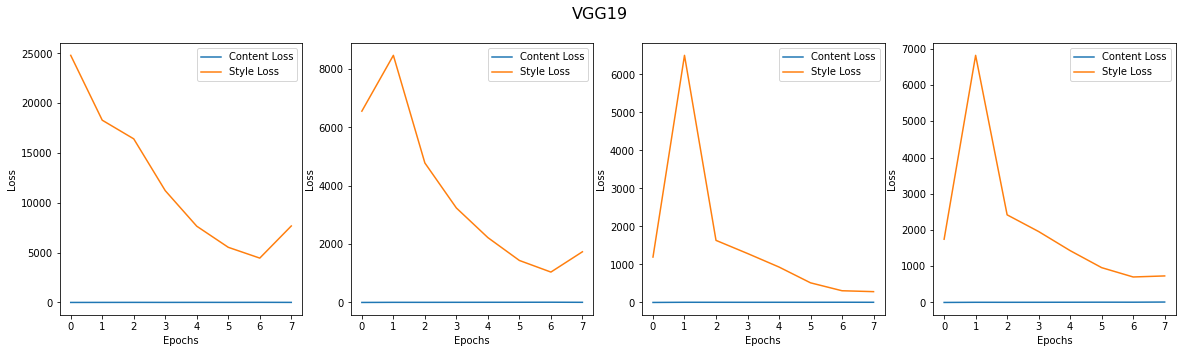

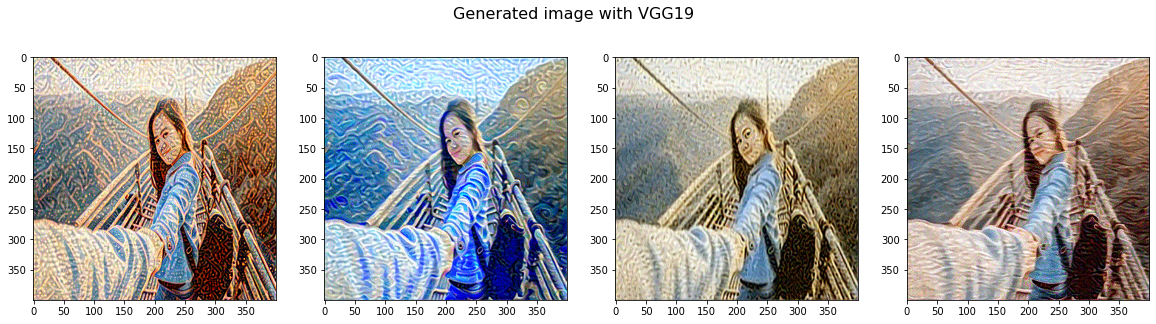

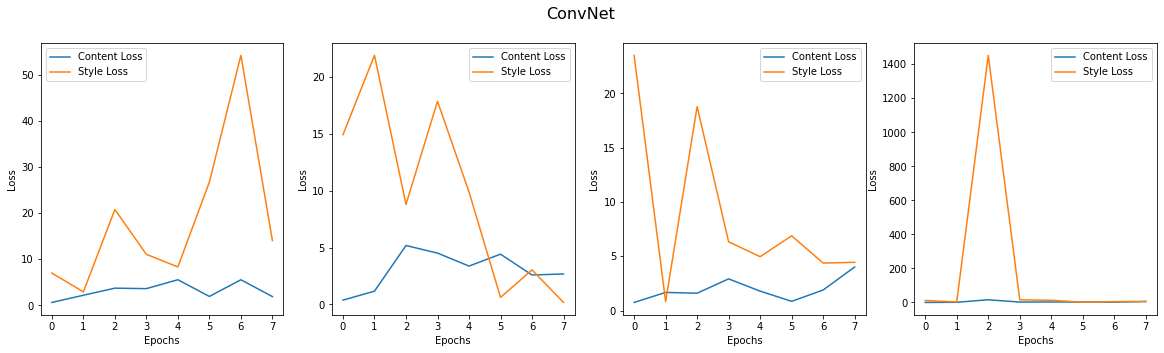

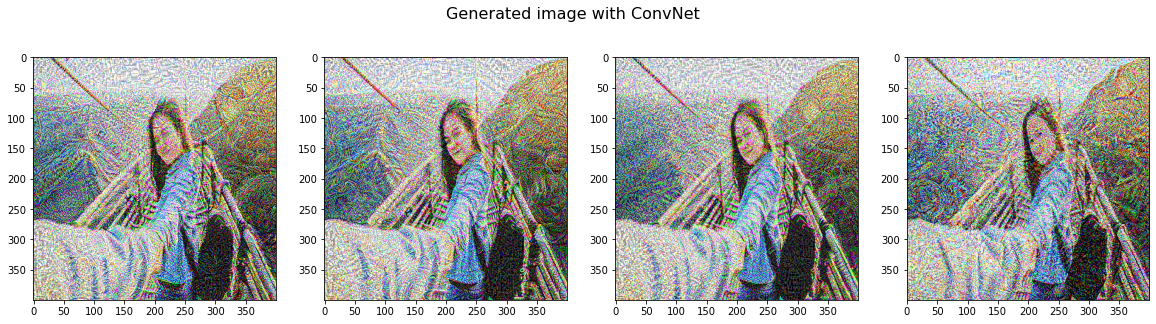

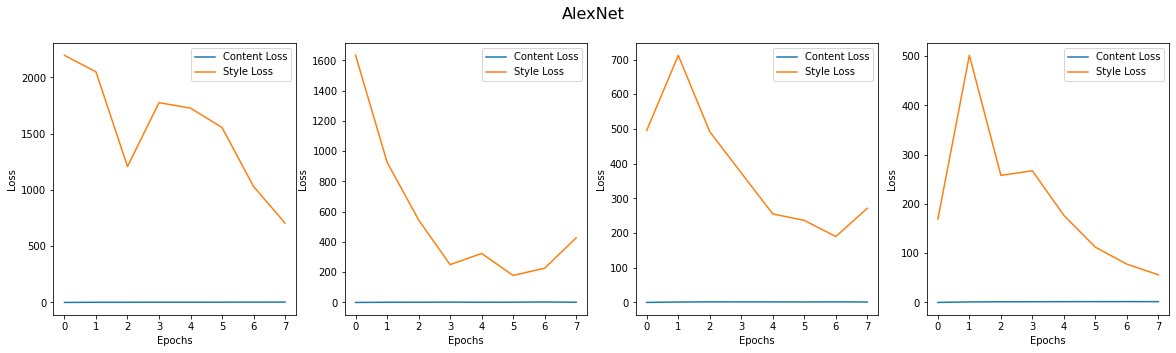

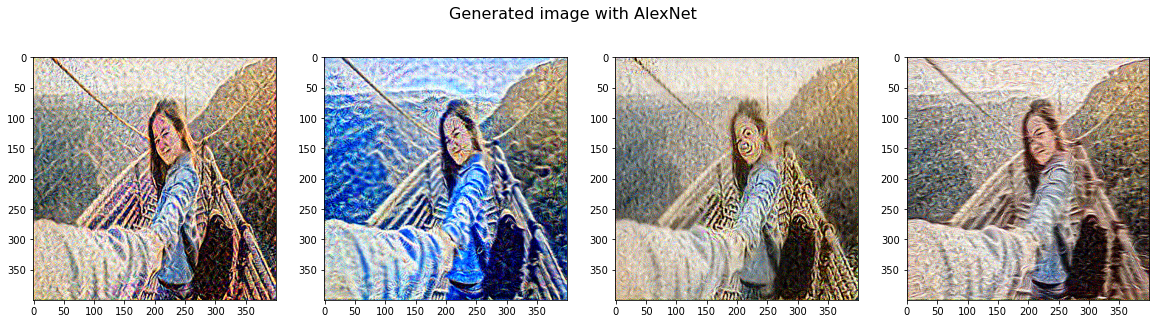

In [ ]:
base_dir = "/content/drive/MyDrive/Dataset/Neural Style Transfer"
test_models = [VGG19StyleTransferModel, ConvNetStyleTransferModel, AlexNetStyleTransferModel]
style_images = ["Batik 3.jpg", "mega-mendung.jpg", "Wayang Kulit.jpg", "keramik 2.jpg"]
content_image = f"{base_dir}/fokus-saat-bekerja.jpg"

def preview_image_axis(image, ax):
  ax.imshow(image)

for index, model in enumerate(test_models):
  metric_fig, metric_axes = plt.subplots(nrows = 1, ncols = 4, figsize = (20, 5))
  style_transfer_fig, style_transfer_axes = plt.subplots(nrows = 1, ncols = 4, figsize = (20, 5))

  for index, style_image_path in enumerate(style_images):
    sample_img, style_img, generated_img = load_dataset_image(content_image, f"{base_dir}/{style_image_path}")
    style_model, optimizer = load_style_transfer_learning_model(model, generated_img)
    content_losses, style_losses, style_transfer_generated_img = train_style_transfer_model(
        style_model, optimizer, sample_img, style_img, generated_img, epochs = 8
    )

    plot_loss_model(content_losses, style_losses, metric_axes[index])
    denormalized_img = get_generated_transfer_style_image(style_transfer_generated_img)
    preview_image_axis(denormalized_img, style_transfer_axes[index])

  style_transfer_fig.suptitle(f"Generated image with {style_model.get_pytorch_model_name()}", fontsize = 16)
  metric_fig.suptitle(style_model.get_pytorch_model_name(), fontsize = 16)
  plt.show()
  time.sleep(1)